# Automatic essay grader

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from matplotlib import pyplot

In [2]:
DATASET_DIR = './data/'
GLOVE_DIR = './glove.6B/'
SAVE_DIR = './'

import os
import pandas as pd

X1 = pd.read_csv('model_1.csv')
y1 = X1['Scaled Score']
X2 = pd.read_csv('model_2.csv')
y2 = X2['Scaled Score']
X1

,essay_id,essay_set,essay,domain1_score,Scaled Score,Max,Min
0,1,1,"Dear local newspaper, I think effects computer...",8.0,0.60,12,2
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0,0.70,12,2
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0,0.50,12,2
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10.0,0.80,12,2
4,5,1,"Dear @LOCATION1, I know having computers has a...",8.0,0.60,12,2
...,...,...,...,...,...,...,...
12973,21626,8,In most stories mothers and daughters are eit...,39.0,0.58,60,10
12974,21628,8,I never understood the meaning laughter is th...,35.0,0.50,60,10
12975,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",46.0,0.72,60,10
12976,21630,8,Trippin' on fen...,40.0,0.60,60,10


In [3]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

def essay_to_wordlist(essay_v, remove_stopwords):
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

In [4]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
from keras import optimizers
import keras.backend as K

def get_model():
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(128, recurrent_dropout=0.4))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse', 'mae','cosine'])
    model.summary()

    return model

Using TensorFlow backend.



--------Fold 1--------

Training Word2Vec Model...


c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 940,977
Trainable params: 940,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
10382/10382 [==============================] - 14s 1ms/step - loss: 0.0617 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1915 - cosine_proximity: -0.9611
Epoch 2/60
10382/10382 [==============================] - 11s 1ms/step - loss: 0.0489 - mean_sq

10382/10382 [==============================] - 10s 970us/step - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1476 - cosine_proximity: -0.9625
Epoch 41/60
10382/10382 [==============================] - 10s 937us/step - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1469 - cosine_proximity: -0.9625
Epoch 42/60
10382/10382 [==============================] - 10s 971us/step - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1474 - cosine_proximity: -0.9628
Epoch 43/60
10382/10382 [==============================] - 10s 943us/step - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.1463 - cosine_proximity: -0.9629
Epoch 44/60
10382/10382 [==============================] - 10s 946us/step - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.1458 - cosine_proximity: -0.9625
Epoch 45/60
10382/10382 [==============================] - 10s 942us/step - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolut

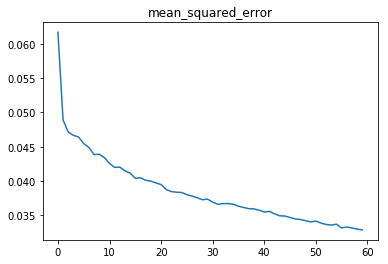

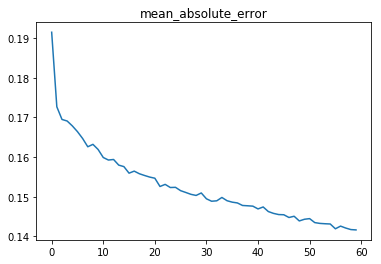

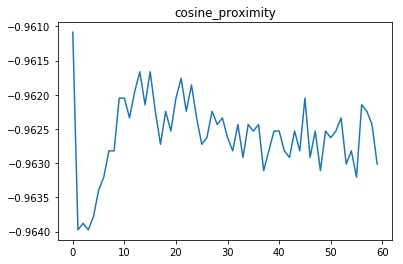

Average Mean score after a 5-fold cross validation:  0.1407


In [8]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score, mean_absolute_error
from keras.callbacks import TensorBoard

cv = KFold(n_splits=5, shuffle=True)
results_1 = []
y_pred_list = []

count = 1
for traincv, testcv in cv.split(X1):
    print("\n--------Fold {}--------\n".format(count))
    X1_test, X1_train, y1_test, y1_train = X1.iloc[testcv], X1.iloc[traincv], y1.iloc[testcv], y1.iloc[traincv]

    
    train_essays = X1_train['essay']
    test_essays = X1_test['essay']
    
    sentences = []
    
    for essay in train_essays:
            sentences += essay_to_sentences(essay, remove_stopwords = True)
            
    num_features = 300 
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    model1 = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

    model1.init_sims(replace=True)
    model1.wv.save_word2vec_format('word2vecmodel_1.bin', binary=True)

    clean_train_essays = []
    
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model1, num_features)
    
    clean_test_essays = []
    for essay_v in test_essays:
        clean_test_essays.append(essay_to_wordlist( essay_v, remove_stopwords=True ))
    testDataVecs = getAvgFeatureVecs( clean_test_essays, model1, num_features )
    
    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    
    lstm_model_d1 = get_model()
    tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
    history = lstm_model_d1.fit(trainDataVecs, y1_train, batch_size=64, epochs=60, callbacks=[tbCallBack])      
    y_pred_1 = lstm_model_d1.predict(testDataVecs)
    
    # Save any one of the 8 models.
    if count == 1:
        lstm_model_d1.save('./model_weights/ml1.h5')
    
    result_1 = mean_absolute_error(y1_test.values,y_pred_1)
    print("MAE: {}".format(result_1))
    results_1.append(result_1)

    count += 1
    pyplot.plot(history.history['mean_squared_error'])
    pyplot.title('mean_squared_error')
    pyplot.savefig('mean_squared_error'+".png")
    pyplot.show()
    pyplot.plot(history.history['mean_absolute_error'])
    pyplot.title('mean_absolute_error')
    pyplot.savefig('mean_absolute_error'+".png")
    pyplot.show()
    pyplot.plot(history.history['cosine_proximity'])
    pyplot.title('cosine_proximity')
    pyplot.savefig('cosine_proximity'+".png")
    pyplot.show()
    break
        

print("Average Mean score after a 5-fold cross validation: ",np.around(np.array(results_1).mean(),decimals=4))

tensorboard --logdir=./Graph --host localhost --port 8088